<a href="https://colab.research.google.com/github/TomChen7896/final_abalone/blob/main/Modeling_and_Predictions_cc7896.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting the Age of Abalones based on Physical Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
# URL to the CSV file
url = "https://raw.githubusercontent.com/TomChen7896/final_abalone/refs/heads/main/abalone.csv"

# Load the CSV into a DataFrame
df = pd.read_csv(url)

# Display the first few rows
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


##Modeling and Interpretations

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [4]:
# split the data into training and test sets
X = df.drop('Rings', axis=1)
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Baseline Model

In [5]:
# predict the majority class
y = df['Rings']
baseline_preds = np.ones(len(y))*y.mean()

# baseline mse
mse = mean_squared_error(y, baseline_preds)

print(f"Mean Squared Error for the baseline model: {mse}")

Mean Squared Error for the baseline model: 10.392777255475611


###K-Nearest Neighbors Regression Model

In [6]:
#create X & y, split into training and testing data
X = df[['Sex',	'Length',	'Diameter',	'Height',	'Whole_weight',	'Shucked_weight',	'Viscera_weight',	'Shell_weight']]
y = df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [7]:
#encode categorical column
cat_col = ['Sex']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = 'passthrough')

In [8]:
#create pipeline for knn regression model
pipe = Pipeline([('encode', transformer), ('model', KNeighborsRegressor())])

In [9]:
#define grid of hyperparameters for number of neighbors
param_grid = {'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}

In [10]:
#perform grid-search w/ cross validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['Sex'])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                                19, 21, 23, 25, 27, 29]},
             scoring='neg_mean_squared_error')

In [11]:
#determine best parameter
grid_search.best_params_

{'model__n_neighbors': 11}

In [12]:
#use 11 neighbors in model
knn = grid_search.best_estimator_

In [13]:
#calculate values for training data
y_train_preds = knn.predict(X_train)
mse_knn = mean_squared_error(y_train, y_train_preds)
r2_score_knn = r2_score(y_train, y_train_preds)

#retrieving the values
print(f"MSE for training data: {mse_knn}")
print(f"R2 score for training data: {r2_score_knn}")

MSE for training data: 3.865191052315212
R2 score for training data: 0.6151314091656529


In [14]:
#calculate values for training data
y_test_preds = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_test_preds)
r2_score_knn = r2_score(y_test, y_test_preds)

#retrieving the values
print(f"MSE for testing data: {mse_knn}")
print(f"R2 score for testing data: {r2_score_knn}")

MSE for testing data: 5.71881055004152
R2 score for testing data: 0.5136750502669569


In [15]:
#determine feature importance
r = permutation_importance(knn, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Sex,0.058552
Length,0.030903
Diameter,0.027167
Height,0.008440
Whole_weight,0.833099
Shucked_weight,0.462039
Viscera_weight,0.015096
Shell_weight,0.238775


###Decision Tree Regression Model

In [16]:
#create X & y, split into training and testing data
X = df[['Sex',	'Length',	'Diameter',	'Height',	'Whole_weight',	'Shucked_weight',	'Viscera_weight',	'Shell_weight']]
y = df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [17]:
#encode categorical column
cat_col = ['Sex']
ohe = OneHotEncoder(sparse_output = False)
encoder = make_column_transformer((ohe,cat_col), verbose_feature_names_out = False, remainder = 'passthrough')

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

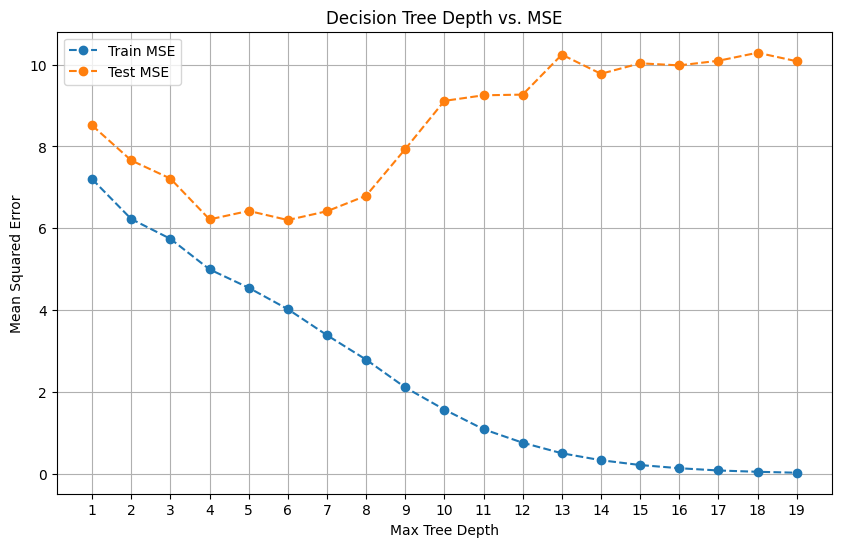

<Figure size 640x480 with 0 Axes>

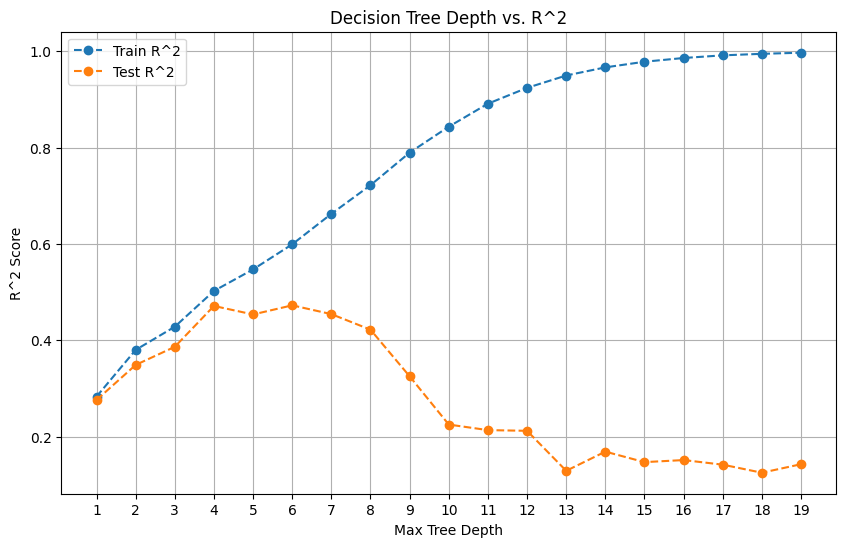

<Figure size 640x480 with 0 Axes>

In [18]:
#find the optimal max depth while avoiding overfitting by plotting the test accuracies & finding the minimum one
# Lists to store MSE and R^2 for training and testing datasets
train_mse = []
test_mse = []
train_r2 = []
test_r2 = []

# Loop over different max depths
for d in range(1, 20):
    # Fit the Decision Tree model with the given max depth
    dtree = DecisionTreeRegressor(max_depth=d).fit(X_train_encoded, y_train)

    # Predictions for training and testing data
    y_train_preds = dtree.predict(X_train_encoded)
    y_test_preds = dtree.predict(X_test_encoded)

    # Calculate and store MSE
    train_mse.append(mean_squared_error(y_train, y_train_preds))
    test_mse.append(mean_squared_error(y_test, y_test_preds))

    # Calculate and store R^2
    train_r2.append(r2_score(y_train, y_train_preds))
    test_r2.append(r2_score(y_test, y_test_preds))

# Plot MSE for train and test datasets
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), train_mse, '--o', label='Train MSE')
plt.plot(range(1, 20), test_mse, '--o', label='Test MSE')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Depth vs. MSE')
plt.show()
plt.savefig('decision_mse.png')

# Plot R^2 for train and test datasets
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), train_r2, '--o', label='Train R^2')
plt.plot(range(1, 20), test_r2, '--o', label='Test R^2')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('Max Tree Depth')
plt.ylabel('R^2 Score')
plt.title('Decision Tree Depth vs. R^2')
plt.show()
plt.savefig('decision_r2.png')

In [19]:
#fit a decision tree model with a max depth = 4 (lowest mse test score on graph)
dtree = DecisionTreeRegressor(max_depth = 4).fit(X_train_encoded, y_train)

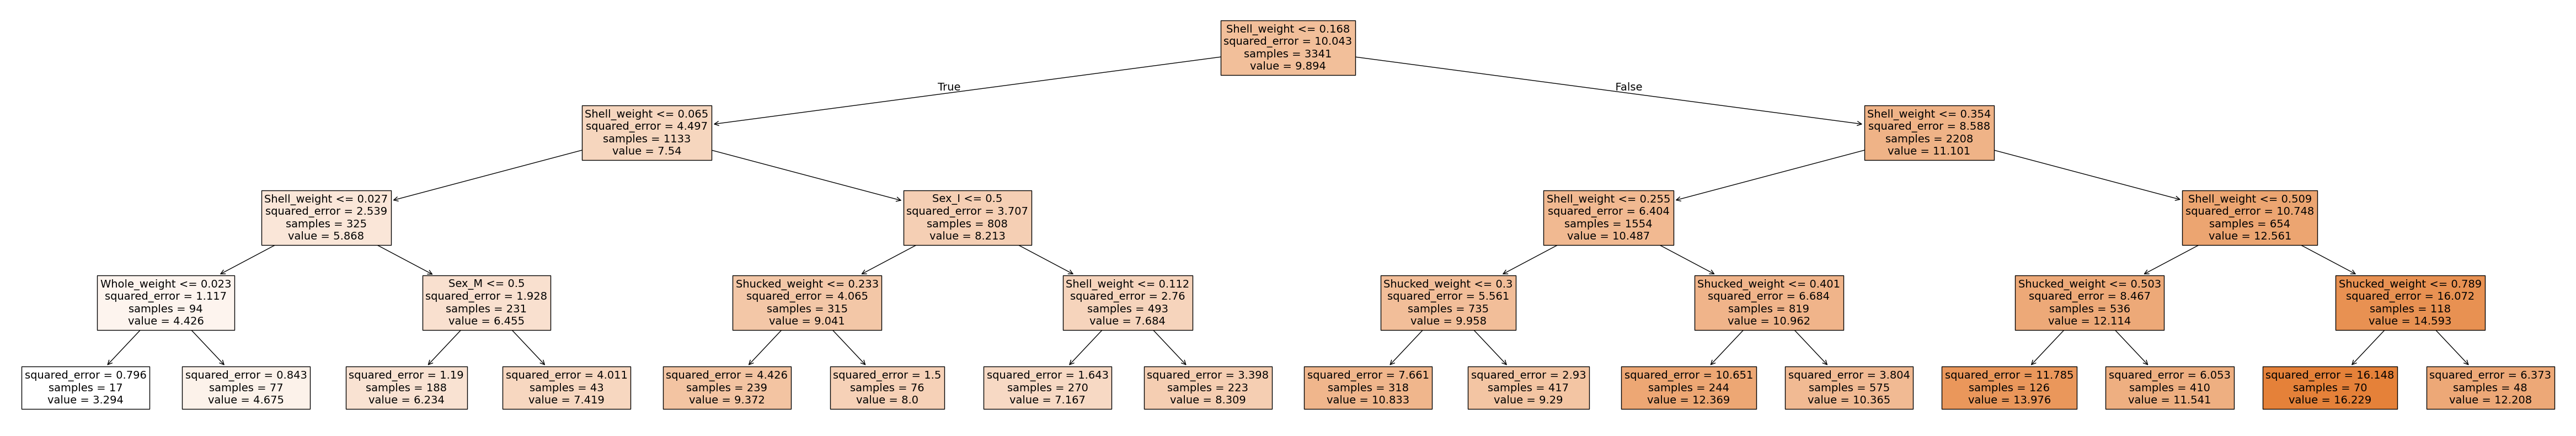

In [20]:
#plot the tree
plt.figure(figsize=(60, 10))
plot_tree(dtree, filled=True, feature_names=encoder.get_feature_names_out().tolist(), fontsize=14);

In [21]:
#calculate mse for training data
y_train_preds = dtree.predict(X_train_encoded)
mean_squared_error(y_train, y_train_preds)

4.996927547443125

In [22]:
#calculate mse for testing data
y_test_preds = dtree.predict(X_test_encoded)
mean_squared_error(y_test, y_test_preds)

6.217709768977742

In [23]:
#calculate R2 for training data
y_train_preds = dtree.predict(X_train_encoded)
r2_score(y_train, y_train_preds)

0.5024410339215157

In [24]:
#calculate R2 for testing data
y_test_preds = dtree.predict(X_test_encoded)
r2_score(y_test, y_test_preds)

0.471248896183351

In [25]:
#determine feature importance
r = permutation_importance(dtree, X_test_encoded, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = encoder.get_feature_names_out().tolist())

,0
Sex_F,0.000000
Sex_I,0.025753
Sex_M,0.005147
Length,0.000000
Diameter,0.000000
Height,0.000000
Whole_weight,-0.000004
Shucked_weight,0.150978
Viscera_weight,0.000000
Shell_weight,1.120226


###Random Forest Regression Model

In [26]:
#create X & y, split into training and testing data
X = df[['Sex',	'Length',	'Diameter',	'Height',	'Whole_weight',	'Shucked_weight',	'Viscera_weight',	'Shell_weight']]
y = df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [27]:
#encode categorical column
cat_col = ['Sex']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = 'passthrough')

In [28]:
#create pipeline for multiple regression model
pipe = Pipeline([('encode', transformer), ('model', RandomForestRegressor())])

In [29]:
#define grid of hyperparameters for number of estimators and max depth
param_grid = {'model__n_estimators': [50, 100, 150, 200],'model__max_depth': [3, 4, 5, 6, 10]}

In [30]:
#perform grid-search w/ cross validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['Sex'])])),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [3, 4, 5, 6, 10],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [31]:
#determine best parameters
grid_search.best_params_

{'model__max_depth': 10, 'model__n_estimators': 200}

In [32]:
#use max depth of 6 & 200 estimators in model
forest = grid_search.best_estimator_

In [33]:
#calculate mse for training data
y_train_preds = forest.predict(X_train)
mean_squared_error(y_train, y_train_preds)

1.621872293810281

In [34]:
#calculate mse for testing data
y_test_preds = forest.predict(X_test)
mean_squared_error(y_test, y_test_preds)

5.35154859023012

In [35]:
#calculate R2 for training data
y_train_preds = forest.predict(X_train)
r2_score(y_train, y_train_preds)

0.8385053427415603

In [36]:
#calculate R2 for testing data
y_test_preds = forest.predict(X_test)
r2_score(y_test, y_test_preds)

0.5449068339711471

In [37]:
#determine feature importance
r = permutation_importance(forest, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Sex,0.026029
Length,0.008552
Diameter,0.006605
Height,0.054249
Whole_weight,0.074566
Shucked_weight,0.615239
Viscera_weight,0.022141
Shell_weight,0.988595


###Ridge Regression Model

In [38]:
from sklearn.linear_model import Ridge

In [39]:
#create X & y, split into training and testing data
X = df[['Sex',	'Length',	'Diameter',	'Height',	'Whole_weight',	'Shucked_weight',	'Viscera_weight',	'Shell_weight']]
y = df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [40]:
#encode categorical column
cat_col = ['Sex']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = 'passthrough')

In [41]:
# Transform the training and testing data using the transformer.
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [42]:
# Initialize Ridge regression model
ridge = Ridge(alpha=1.0)

In [43]:
# Fit the model to the training data
ridge.fit(X_train_transformed, y_train)

Ridge()

In [44]:
# Make predictions on the test set
y_train_pred = ridge.predict(X_train_transformed)
y_pred = ridge.predict(X_test_transformed)

In [45]:
# Evaluate the training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Mean Squared Error: {mse_train}")
print(f"R-squared: {r2_train}")

Mean Squared Error: 4.604362049152808
R-squared: 0.5415299503792619


In [46]:
# Evaluate the testing data
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error_test: {mse}")
print(f"R-squared_test: {r2}")

Mean Squared Error_test: 5.8050775482877235
R-squared_test: 0.5063389454565954


In [47]:
# Get feature names after transformation
feature_names = list(transformer.named_transformers_['onehotencoder'].get_feature_names_out(['Sex'])) + list(X.columns[1:])

# Extract Ridge coefficients
coefficients = pd.DataFrame({
    'Feature': feature_names,  # Use transformed feature names
    'Coefficient': ridge.coef_
})

coefficients

,Feature,Coefficient
0,Sex_I,-0.791229
1,Sex_M,0.097017
2,Length,2.342805
3,Diameter,7.049101
4,Height,6.753599
5,Whole_weight,7.046510
6,Shucked_weight,-17.085839
7,Viscera_weight,-6.795782
8,Shell_weight,10.046177
